<a href="https://colab.research.google.com/github/rtajeong/M4_new/blob/main/lab_101_Transformer_keras_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer example
- transformer-based Sentiment Classifier for the NLTK movie reviews dataset.
- https://colab.research.google.com/github/alvinntnu/NTNU_ENC2045_LECTURES/blob/main/nlp/dl-transformers-keras.ipynb#scrollTo=mnYds08_WZGB

In [ ]:
import nltk, random
import numpy as np
from nltk.corpus import movie_reviews
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
## checking tf version
print(tf.__version__)

2.13.0


In [ ]:
# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Data

In [ ]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [ ]:
## loading corpus
documents = [(' '.join(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)  #in-place shuffle

In [ ]:
np.array(documents).shape

(2000, 2)

In [ ]:
documents[0]

('for those who associate italian cinema with fellini and " high art , " the son \' s room is an inventive , subtle alternative . written by , directed , and starring nanni moretti , it takes us through the slow , complicated path of bereavement . slow is the best description for the film at first . it takes its time in establishing the habits of what appears to be a normal , happy family . father and mother both work but still find the time to support their son and daughter through homework and after school activities . they laugh , spend free time together , and reprimand the kids for innocent wrongs with a sigh and soft pat on the shoulder . you get the feeling there is open communication and unconditional love amongst the foursome . but suddenly , the son is found to be dead after a diving accident . the family dynamics begin an unpredictable descent that gives the narrative strength when you least expect it , but can also be trying on the attention span . though the film drags and

In [ ]:
## Train-Test Split
train_set, test_set = train_test_split(documents, test_size=0.1, random_state=42)

In [ ]:
## Hyperparameters fot tokenizer
vocab_size = 10000
maxlen = 200  # Only consider the last 200 words of each movie review

## texts vs. labels
texts = np.array([t for (t, l) in train_set])
labels = np.array([1 if l == 'pos' else 0 for (t, l) in train_set])
## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
## fit tokenizer
tokenizer.fit_on_texts(texts)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(texts)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=maxlen,
                                                              truncating='pre',
                                                              padding='pre')

In [ ]:
texts_to_int_pad.shape

(1800, 200)

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels

## Perform same vectorization on testing set
x_val_text = np.array([t for (t,l) in test_set])

x_val = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)

y_val = np.array([1 if l == 'pos' else 0 for (t, l) in test_set])


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1800, 200)
(1800,)
(200, 200)
(200,)


In [ ]:
# Check Total Vocab Size
total_vocab_size = len(tokenizer.word_index) + 1
print('Total Vocabulary Size (Untrimmed): %d' % total_vocab_size)
print('Vocabulary Size (trimmed): %d' % vocab_size)

Total Vocabulary Size (Untrimmed): 37864
Vocabulary Size (trimmed): 10000


## Define Classifier Architecture

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

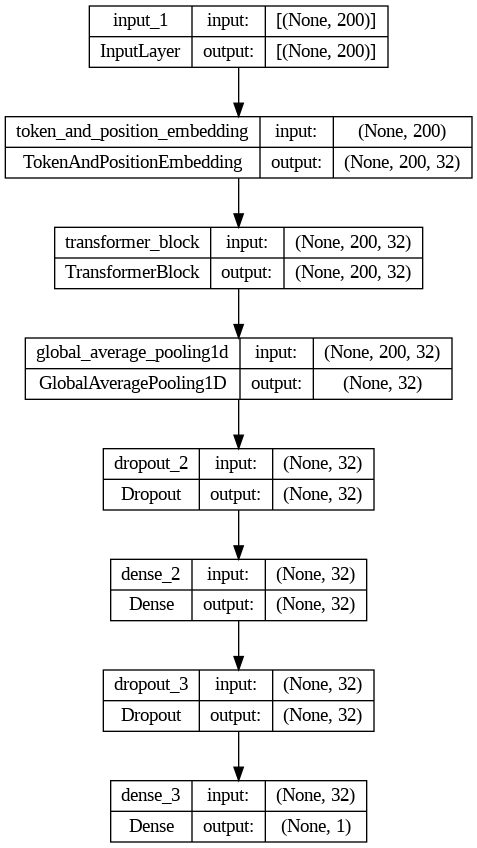

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
15/15 [==============================] - 13s 641ms/step - loss: 0.6927 - accuracy: 0.5294 - val_loss: 0.7173 - val_accuracy: 0.4050
Epoch 2/10
15/15 [==============================] - 7s 463ms/step - loss: 0.6643 - accuracy: 0.5983 - val_loss: 0.6623 - val_accuracy: 0.5700
Epoch 3/10
15/15 [==============================] - 11s 722ms/step - loss: 0.5644 - accuracy: 0.7672 - val_loss: 0.5952 - val_accuracy: 0.6650
Epoch 4/10
15/15 [==============================] - 7s 481ms/step - loss: 0.3837 - accuracy: 0.8700 - val_loss: 0.4490 - val_accuracy: 0.7950
Epoch 5/10
15/15 [==============================] - 9s 600ms/step - loss: 0.1898 - accuracy: 0.9422 - val_loss: 0.4228 - val_accuracy: 0.7950
Epoch 6/10
15/15 [==============================] - 7s 465ms/step - loss: 0.0552 - accuracy: 0.9922 - val_loss: 0.4666 - val_accuracy: 0.8150
Epoch 7/10
15/15 [==============================] - 9s 578ms/step - loss: 0.0154 - accuracy: 0.9994 - val_loss: 0.7239 - val_accuracy: 0.7650
Epoc

## Plotting the training Result

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 100


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

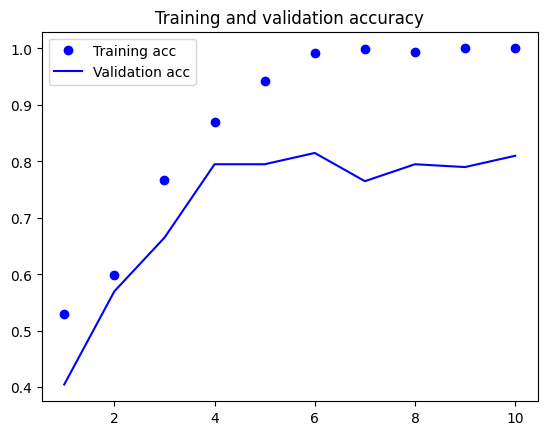

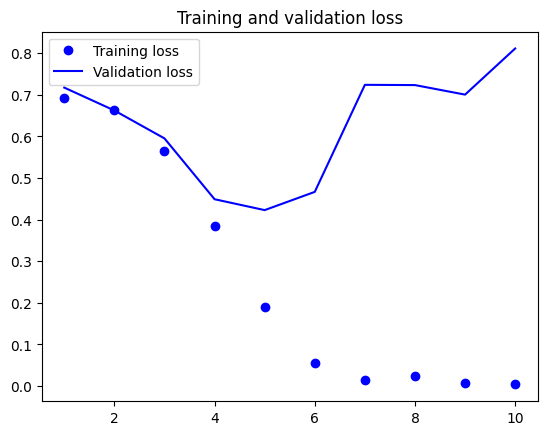

In [ ]:
plot1(history)

- Given the small corpus size, it is clear to see that our model starts to overfit the training set quite a bit after the first few epochs (e.g, after the fourth epoch).
- In real application development, we may improve the model by:
  - increasing the datasets
  - increasing the embedding dimensions
  - using pre-trained embeddings
  - playing with the transformer blocks in terms of depths and widths of the layers
  - including dropouts, regularization, and normalization

## References
- This unit is based on the official keras tutorial: Text classification with transfomer(https://keras.io/examples/nlp/text_classification_with_transformer/)
- Please read Peter Bloem's blog post on Transformers: Transformers From Scratch. (https://peterbloem.nl/blog/transformers) Highly recommended! Very comprehensive introduction of the attention mechanism and transformers.

# Multihead Attention class in keras
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention
- MultiheadAttention(num_head, key_dim)
  - num_heads: no of attention head
  - key_dim: The dimensionality of the key and value vectors for each attention head.
- input:
  - query (batch_size, query_length, num_features)
  - value (batch_size, value_length, num_features)
  - key (batch_size, key_length, num_features)
- output
  - attention_output (batch_size, query_length, num_features)
  - the output will have the same shape as the query input, where each element represents the weighted sum of the values based on the attention weights computed by the layer.
  - The MultiHeadAttention layer can also be used for self-attention within the encoder or decoder. In this case, both the query and key inputs are derived from the same sequence. However, the query_length and key_length dimensions can still be different if different parts of the sequence have different contextual dependencies or importance.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention

In [ ]:
layer = MultiHeadAttention(num_heads=4, key_dim=8)
target = tf.keras.Input(shape=[8, 16]) # Q
source = tf.keras.Input(shape=[4, 16]) # K and V
output_tensor, weights = layer(target, source, return_attention_scores=True)
print(output_tensor.shape)  # (None, 8, 16)
print(weights.shape)        # output of softmax
                            # (None(batch_size), num_heads, query length, key length)
num_params = layer.count_params()
print("Number of learnable parameters:", num_params)
((16*8+8)*3)*4+(4*8)*16+16

(None, 8, 16)
(None, 4, 8, 4)
Number of learnable parameters: 2160


2160

- 8개의 출력 token 각각에 대해 입력 token 4 개에 대한 weight (각 token 의 dim 은 16)
- The (None, 2, 8, 4) shape indicates that for each batch, there are 2 attention heads, and for each attention head, there are attention weights of shape (8, 4), representing the attention scores for the query-key pairs.

In [ ]:
# number of parameters
# each lookup for Q, V, K: 16*8+8
# total (2 heads): (16*8+8)*3*4
# final linear: input (8*4) -> 16 (32*16+16)
(16*8+8)*3*4 + 32*16+16    # 2160

2160

In [ ]:
layer = MultiHeadAttention(num_heads=6, key_dim=4)
target = tf.keras.Input(shape=[8, 16]) # Q
source = tf.keras.Input(shape=[4, 16]) # K and V
output_tensor, weights = layer(target, source, return_attention_scores=True)
print(output_tensor.shape)
print(weights.shape)
num_params = layer.count_params()
print("Number of learnable parameters:", num_params)
print((16*4+4)*3*6 + (4*6)*16+16)

(None, 8, 16)
(None, 6, 8, 4)
Number of learnable parameters: 1624
1624


# Multi-Head Attention from Scratch in TensorFlow and Keras ???)
- https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/
- not confirmed yet

In [ ]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class _MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(_MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        # self.head_dim = self.d_model // self.heads  ###
        self.head_dim = self.d_model                  ###

        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values

        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [ ]:
layer2 = _MultiHeadAttention(h=1, d_k=4, d_v=4, d_model=16)
target = tf.keras.Input(shape=[8, 16]) # Q
source = tf.keras.Input(shape=[4, 16]) # K and V
output_tensor = layer2(target, source, source)
print(output_tensor.shape)

num_params = layer2.count_params()
print("Number of learnable parameters:", num_params)

(None, 8, 16)
Number of learnable parameters: 284


In [ ]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(layer2.trainable_weights)
non_trainable_count = count_params(layer2.non_trainable_weights)
trainable_count, non_trainable_count

(284, 0)

In [ ]:
print(layer2.W_q.weights[0].shape)
print(layer2.W_k.weights[0].shape)
print(layer2.W_v.weights[0].shape)
print(layer2.W_o.weights[0].shape)


(16, 4)
(16, 4)
(16, 4)
(4, 16)


- not confirmed yet...

In [ ]:
# Testing
import numpy as np

input_seq_length = 5  # Maximum length of the input sequence
h = 8                 # Number of self-attention heads
d_k = 64              # Dimensionality of the linearly projected queries and keys
d_v = 64              # Dimensionality of the linearly projected values
d_model = 512         # Dimensionality of the model sub-layers' outputs
batch_size = 64       # Batch size from the training process

# queries = np.random.random((batch_size, input_seq_length, d_k))
# keys = np.random.random((batch_size, input_seq_length, d_k))
# values = np.random.random((batch_size, input_seq_length, d_v))
queries = np.random.random((batch_size, input_seq_length, d_model))
keys = np.random.random((batch_size, input_seq_length, d_model))
values = np.random.random((batch_size, input_seq_length, d_model))

layer3 = _MultiHeadAttention(h, d_k, d_v, d_model)
print(layer3(queries, keys, values).shape)
layer3.count_params()

(64, 5, 512)


131776

In [ ]:
(512*64+64)*3*8

787968

In [ ]:
print(layer3.W_q.weights[0].shape)
print(layer3.W_k.weights[0].shape)
print(layer3.W_v.weights[0].shape)
print(layer3.W_o.weights[0].shape)

(512, 64)
(512, 64)
(512, 64)
(64, 512)


- in the original paper,
  - "We did not find that splitting the query, keys, and values into multiple heads improved performance. In fact, we found that it actually decreased performance."
  - "We believe that this is because the attention mechanism in Transformers is already very powerful, and splitting the query, keys, and values into multiple heads does not add any additional information."
  - d_model=512, d_q = d_k = d_v = 64
  - seq length = 512, num_heads=8

In [ ]:
layer = my_MultiHeadAttention(num_heads=6, key_dim=4)
target = tf.keras.Input(shape=[8, 16]) # Q
source = tf.keras.Input(shape=[4, 16]) # K and V
output_tensor = layer([target, source, source])
print(output_tensor.shape)
num_params = layer.count_params()
print("Number of learnable parameters:", num_params)
(16*4+4)*3*6 + (4*6)*16+16

(None, None, 16)
Number of learnable parameters: 1224


1624

# Sinusoidal Positional Encoding
- The sine and cosine functions have values in [-1, 1], which keeps the values of the positional encoding matrix in a normalized range.
- As the sinusoid for each position is different, you have a unique way of encoding each position.
- You have a way of measuring or quantifying the similarity between different positions, hence enabling you to encode the relative positions of words.

- P(k, 2i)  = sin(k/exp(2i/d))
- P(k,2i+1) = cos(k/exp(2i/d))-

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=8, d=4, n=10000)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.00999983  0.99995   ]
 [ 0.90929743 -0.41614684  0.01999867  0.99980001]
 [ 0.14112001 -0.9899925   0.0299955   0.99955003]
 [-0.7568025  -0.65364362  0.03998933  0.99920011]
 [-0.95892427  0.28366219  0.04997917  0.99875026]
 [-0.2794155   0.96017029  0.05996401  0.99820054]
 [ 0.6569866   0.75390225  0.06994285  0.997551  ]]


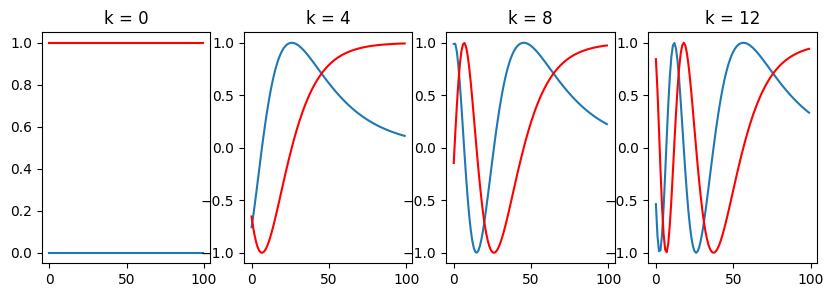

In [ ]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)   # i <- x
    y1 = np.sin(k/denominator)
    y2 = np.cos(k/denominator)
    plt.plot(x, y1)
    plt.plot(x, y2, c='r')
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(10, 3))
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

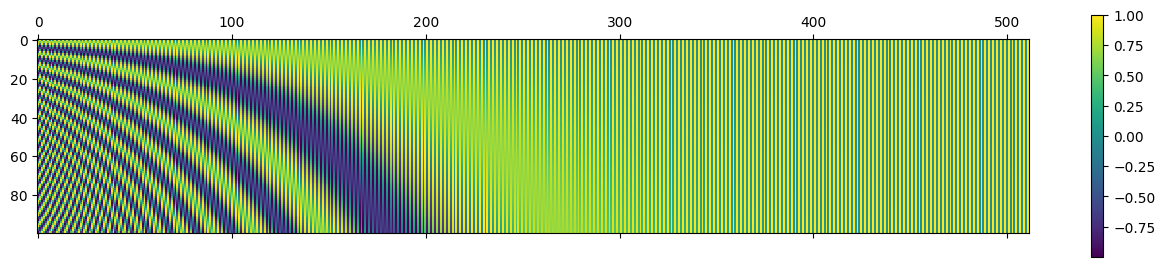

In [ ]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

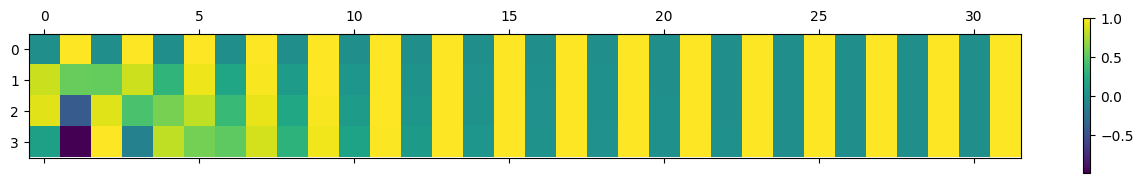

In [ ]:
P = getPositionEncoding(seq_len=4, d=32, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

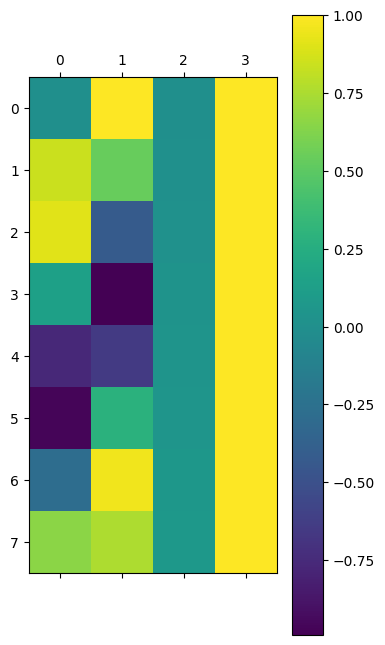

In [ ]:
P = getPositionEncoding(seq_len=8, d=4, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

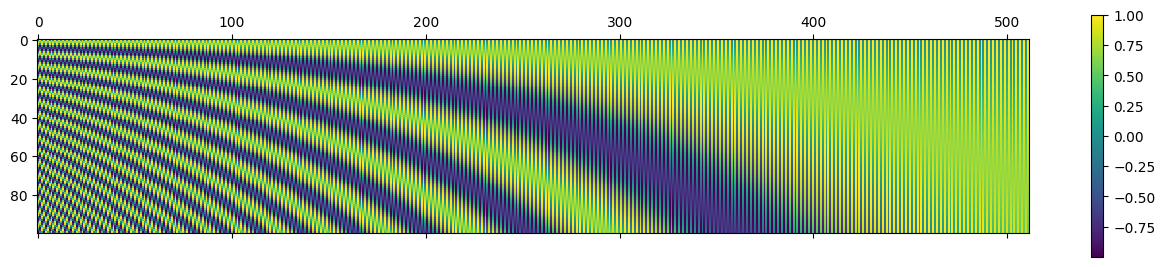

In [ ]:
P = getPositionEncoding(seq_len=100, d=512, n=100)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

# Sub-word Tokenizer
- In the GPT models, the tokens used are typically subword units rather than individual characters or complete words.

In [ ]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


In [ ]:
import requests
import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
# the most common way: whole words as tokens
tokenizer = tf_text.WhitespaceTokenizer()
tokens = tokenizer.tokenize(["I ain't here, you are there, he isn't going."])
print(tokens.to_list())

[[b'I', b"ain't", b'here,', b'you', b'are', b'there,', b'he', b"isn't", b'going.']]


In [ ]:
# based on Unicode script boundaries
tokenizer = tf_text.UnicodeScriptTokenizer()
tokens = tokenizer.tokenize(["I ain't here, you are there, he isn't going."])
print(tokens.to_list())

[[b'I', b'ain', b"'", b't', b'here', b',', b'you', b'are', b'there', b',', b'he', b'isn', b"'", b't', b'going', b'.']]


- Subword tokenizers: can be used with a smaller vocabulary, and allow the model to have some information about novel words.
- WordpieceTokenizer(): Tokenizes a tensor of UTF-8 string tokens into subword pieces.


## Subword tokenization in OpenAI - tiktoken
- Byte pair encoding (BPE) is a way of converting text into tokens

In [2]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.5 MB/s eta 0:00:00


In [3]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")   # used in GPT 3.5 turbo, GPT 4
assert enc.decode(enc.encode("hello world")) == "hello world"


In [5]:
enc.encode("hello world")

[15339, 1917]

In [6]:
enc.n_vocab

100277

In [7]:

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4")
enc.n_vocab

100277

In [8]:
text = "Isn't this world worth living in? A good sample word for subworld tokenization is 'unhapiness'."
enc.encode(text)

[89041,
 956,
 420,
 1917,
 5922,
 5496,
 304,
 30,
 362,
 1695,
 6205,
 3492,
 369,
 1207,
 14957,
 4037,
 2065,
 374,
 364,
 359,
 38910,
 1918,
 4527]

In [9]:
enc.decode(enc.encode(text))

"Isn't this world worth living in? A good sample word for subworld tokenization is 'unhapiness'."

In [10]:
for i in enc.encode(text):
    print(i, enc.decode([i]))

89041 Isn
956 't
420  this
1917  world
5922  worth
5496  living
304  in
30 ?
362  A
1695  good
6205  sample
3492  word
369  for
1207  sub
14957 world
4037  token
2065 ization
374  is
364  '
359 un
38910 hap
1918 iness
4527 '.


In [11]:
text = "I ain't here, i am going there carelessly. you aren't there, he is not going."
for i in enc.encode(text):
    print(i, enc.decode([i]))

40 I
37202  ain
956 't
1618  here
11 ,
602  i
1097  am
2133  going
1070  there
2512  care
16117 lessly
13 .
499  you
7784  aren
956 't
1070  there
11 ,
568  he
374  is
539  not
2133  going
13 .


- gpt2 has different encoding

In [12]:
text = "Isn't this world worth living in? A good sample word for subworld tokenization is 'unhapiness'."

enc = tiktoken.get_encoding('gpt2')
print(enc.n_vocab)

for i in enc.encode(text):
    print(i, enc.decode([i]))

50257
41451 Isn
470 't
428  this
995  world
2861  worth
2877  living
287  in
30 ?
317  A
922  good
6291  sample
1573  word
329  for
850  sub
6894 world
11241  token
1634 ization
318  is
705  '
403 un
45897 hap
1272 iness
4458 '.


## Keras tokenizer
- word level
- character level
- subword level - use WordpieceTokenizer in tensorflow

In [ ]:
from tensorflow import keras

In [ ]:
text = ["Isn't this world worth living in?",
        "한국말도 잘 해요.",
        "A good sample word for subworld tokenization is 'unhapiness'."]

t = keras.preprocessing.text.Tokenizer()
t.fit_on_texts(text)
t.texts_to_sequences(text)

[[1, 2, 3, 4, 5, 6], [7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [ ]:
t.word_index

{"isn't": 1,
 'this': 2,
 'world': 3,
 'worth': 4,
 'living': 5,
 'in': 6,
 '한국말도': 7,
 '잘': 8,
 '해요': 9,
 'a': 10,
 'good': 11,
 'sample': 12,
 'word': 13,
 'for': 14,
 'subworld': 15,
 'tokenization': 16,
 'is': 17,
 "'unhapiness'": 18}

In [ ]:
t = keras.preprocessing.text.Tokenizer(char_level=True)
t.fit_on_texts(text)
t.word_index

{' ': 1,
 'i': 2,
 'o': 3,
 's': 4,
 'n': 5,
 't': 6,
 'r': 7,
 'w': 8,
 'l': 9,
 'd': 10,
 'a': 11,
 "'": 12,
 'h': 13,
 'e': 14,
 'g': 15,
 '.': 16,
 'p': 17,
 'u': 18,
 'v': 19,
 '?': 20,
 '한': 21,
 '국': 22,
 '말': 23,
 '도': 24,
 '잘': 25,
 '해': 26,
 '요': 27,
 'm': 28,
 'f': 29,
 'b': 30,
 'k': 31,
 'z': 32}

In [ ]:
try:
    print(t.index_word[0])
except:
    print("error: no word assigned for index 0.")

error: no word assigned for index 0.


## transformer

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, WordpieceTokenizer

text = "Isn't this world worth living in?,\
        A good sample word for subworld tokenization is 'unhapiness'."
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.tokenize(text)

['isn',
 "'",
 't',
 'this',
 'world',
 'worth',
 'living',
 'in',
 '?',
 ',',
 'a',
 'good',
 'sample',
 'word',
 'for',
 'sub',
 '##world',
 'token',
 '##ization',
 'is',
 "'",
 'un',
 '##ha',
 '##pine',
 '##ss',
 "'",
 '.']

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
# there is also a wordpiece_tokenizer inside BertTokenizer
# in fact, BertTokenizer uses wordpiece_tokenizer inside.
tokenizer2 = tokenizer.wordpiece_tokenizer

In [ ]:
tokenizer2.tokenize(text)

['[UNK]',
 'this',
 'world',
 'worth',
 'living',
 'in',
 '##?',
 '##,',
 '[UNK]',
 'good',
 'sample',
 'word',
 'for',
 'sub',
 '##world',
 'token',
 '##ization',
 'is',
 "'",
 '##un',
 '##ha',
 '##pine',
 '##ss',
 "##'",
 '##.']

-

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

text = "Hello, how are you?"
tokens = tokenizer.tokenize(text)

print(tokens)
print(tokenizer.tokenize("I ain't here, you are there, he isn't going. unhappiness"))

['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']
['I', 'Ġain', "'t", 'Ġhere', ',', 'Ġyou', 'Ġare', 'Ġthere', ',', 'Ġhe', 'Ġisn', "'t", 'Ġgoing', '.', 'Ġunh', 'appiness']
